# Skin Disease Detection System Using PyTorch (ResNet34 VS EfficientNetB0)


## Importing Data & Basic Setup


In [2]:
# !pip install kagglehub

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shubhamgoel27/dermnet")

# print("Path to dataset files:", path)

100%|██████████| 1.72G/1.72G [00:15<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shubhamgoel27/dermnet/versions/1


In [38]:
path = "Data/Dermnet/VARIANT" # 3 Diseases Only

train_dir = path + "/train"
test_dir = path + "/test"

In [39]:
import torch
import torchvision
from torchvision import transforms
from pathlib import Path
from torch import nn

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.xpu.is_available():
    device = "xpu"
else: device = "cpu"
device

'cpu'

## Transforms, Dataset & Dataloader


In [40]:
from torchvision import transforms

# Data augmentation has shown to reduce overfitting. My aim with these augments is to make the model find patterns V/S rote memorization.

train_transform = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])
test_transfrom = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(train_dir,
                                                 transform=train_transform,
                                                 target_transform=None)

test_dataset = torchvision.datasets.ImageFolder(test_dir,
                                                 transform=test_transfrom,
                                                 target_transform=None)

img, label = train_dataset[1][0], train_dataset[1][1]

img.shape

torch.Size([3, 224, 224])

In [41]:
len(train_dataset)

300

In [42]:
class_names = train_dataset.classes
len(class_names)

3

Text(0.5, 1.0, 'Acne and Rosacea Photos')

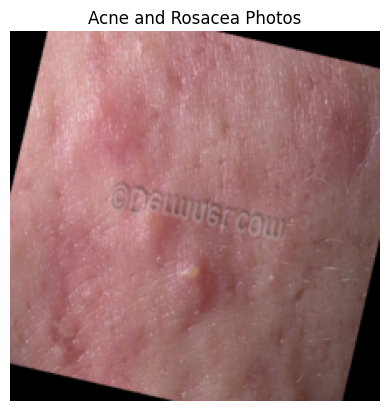

In [43]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [44]:
import os
os.cpu_count()

8

In [45]:
from torch.utils.data import DataLoader

BATCH_SIZE = 50

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=8)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=8)

len(train_dataloader), len(test_dataloader)

(6, 2)

In [46]:
num_classes = len(train_dataset.classes)

## Model


In [47]:
import torch
import torchvision.models as models
from torch import nn
# import "./efficientnetb0_model_ValAcc_44_______direction_good.pth" as weights

model = torch.load("models/efficientnetb0_model_ValAcc_44_______direction_good.pth", weights_only=False, map_location=torch.device('cpu'))
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
import torch
from torch import nn
from torchvision.models import resnet34, ResNet34_Weights

model_1 = resnet34(weights=ResNet34_Weights.DEFAULT)

model_1.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=num_classes, bias=True)
)

# Freeze all layers
for param in model_1.parameters():
  param.requires_grad = False

for param in model_1.fc.parameters():
  param.requires_grad = True

model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

model_2 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
)

## Custom Functions For Training & Testing


In [49]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_step(model: nn.Module,
               dataloader,
               loss_fn,
               optimizer,
               acc_fn,
               device):

    """
    Function to train our model with clearly set hyperparameters
    """

    train_acc, train_loss = 0,0

    for batch, (X,y) in enumerate(dataloader):
        model.train().to(device)
        X, y = X.to(device), y.to(device)
        logits = model(X).to(device)

        y=y.to(torch.int64).to(device)

        loss = loss_fn(logits, y)
        acc = acc_fn(preds=logits.argmax(dim=1), target=y)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 2 == 0:
            print(f"Went through {batch} batches")
            print(f"|| Train_Accuracy: {acc:.3f} & Train_Loss: {loss:.3f} ||")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"|| Train_Accuracy: {train_acc:.3f} & Train_Loss: {train_loss:.3f} ||")
    print("Training for current epoch completed successfully.")
    return train_acc, train_loss

def test_step(model: nn.Module,
             dataloader,
             loss_fn,
             acc_fn,
             device):

    """
    Function to test our model with clearly set hyperparameters
    """

    test_acc, test_loss = 0,0

    for batch, (X,y) in enumerate(dataloader):
        model.eval()
        X, y = X.to(device), y.to(device)
        with torch.inference_mode():
            logits = model(X).to(device)

            y=y.to(torch.int64)

            loss = loss_fn(logits, y)
            acc = acc_fn(preds=logits.argmax(dim=1), target=y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 2 == 0:
                print(f"Went through {batch} batches")
                print(f"|| Test_Acc: {acc:.3f} & Test_Loss: {loss:.3f} ||")

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"|| Test_Accuracy: {test_acc:.3f} & Test_Loss: {test_loss:.3f} ||")
    print("Testing for current epoch completed successfully.")
    return test_acc, test_loss

def train(model: nn.Module,
        train_dataloader,
        test_dataloader,
        loss_fn,
        optimizer,
        acc_fn,
        device,
        epochs: int):
    """
    Function to train the model for a specified number of epochs
    """

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    EPOCHS = epochs

    for epoch in tqdm(range(EPOCHS)):
      start= timer()
      print(f"\n\nStarting Epoch: {epoch}-----------------------------")
      train_acc, train_loss = train_step(model, train_dataloader, loss_fn, optimizer, acc_fn, device)
      test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)
      print(f"\nEnding Epoch: {epoch}-----------------------------")
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      end= timer()
      print(f"Time Taken For Current Epoch: {end-start:.2f} seconds")
    return results

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=0.0001)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

## Training Loop


In [51]:
# from timeit import default_timer as timer

# start = timer()

# EPOCHS = 10

# model_0_results = train(model=model,
#                         train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader,
#                         loss_fn=loss_fn,
#                         optimizer=optimizer,
#                         acc_fn=acc_fn,
#                         device=device,
#                         epochs=EPOCHS)

# end = timer()

# print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

In [52]:
# model_0_results

In [53]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [54]:
# plot_loss_curves(model_0_results)

In [55]:
from pathlib import Path

model_path = Path("/models")
path = model_path / "model.pth"

model_path.mkdir(
    parents=True,
    exist_ok=True
)

torch.save(obj=model,
           f=path)

print("Save Success")

Save Success


In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=1e-2,
                            momentum=0.9,
                            weight_decay=0.0001)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

In [76]:
from timeit import default_timer as timer

start = timer()

EPOCHS = 120

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        acc_fn=acc_fn,
                        device=device,
                        epochs=EPOCHS)

end = timer()

print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

  0%|          | 0/120 [00:00<?, ?it/s]



Starting Epoch: 0-----------------------------
Went through 0 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.712 ||
Went through 2 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.846 ||
Went through 4 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.557 ||
|| Train_Accuracy: 76.000 & Train_Loss: 0.720 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.930 ||


  1%|          | 1/120 [01:02<2:04:13, 62.64s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.973 ||
Testing for current epoch completed successfully.

Ending Epoch: 0-----------------------------
Time Taken For Current Epoch: 62.64 seconds


Starting Epoch: 1-----------------------------
Went through 0 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.791 ||
Went through 2 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.600 ||
Went through 4 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.674 ||
|| Train_Accuracy: 71.667 & Train_Loss: 0.829 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.913 ||


  2%|▏         | 2/120 [02:07<2:05:31, 63.82s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.970 ||
Testing for current epoch completed successfully.

Ending Epoch: 1-----------------------------
Time Taken For Current Epoch: 64.65 seconds


Starting Epoch: 2-----------------------------
Went through 0 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.525 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.642 ||
Went through 4 batches
|| Train_Accuracy: 60.000 & Train_Loss: 1.016 ||
|| Train_Accuracy: 70.667 & Train_Loss: 0.761 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.896 ||


  2%|▎         | 3/120 [03:10<2:04:05, 63.64s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.967 ||
Testing for current epoch completed successfully.

Ending Epoch: 2-----------------------------
Time Taken For Current Epoch: 63.42 seconds


Starting Epoch: 3-----------------------------
Went through 0 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.745 ||
Went through 2 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.662 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 1.027 ||
|| Train_Accuracy: 75.000 & Train_Loss: 0.765 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.898 ||


  3%|▎         | 4/120 [04:15<2:04:04, 64.18s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.973 ||
Testing for current epoch completed successfully.

Ending Epoch: 3-----------------------------
Time Taken For Current Epoch: 65.00 seconds


Starting Epoch: 4-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 1.018 ||
Went through 2 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.586 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.007 ||
|| Train_Accuracy: 69.333 & Train_Loss: 0.870 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.890 ||


  4%|▍         | 5/120 [05:19<2:02:38, 63.99s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.973 ||
Testing for current epoch completed successfully.

Ending Epoch: 4-----------------------------
Time Taken For Current Epoch: 63.66 seconds


Starting Epoch: 5-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.881 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.771 ||
Went through 4 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.905 ||
|| Train_Accuracy: 76.667 & Train_Loss: 0.803 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.884 ||


  5%|▌         | 6/120 [06:22<2:00:49, 63.59s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.964 ||
Testing for current epoch completed successfully.

Ending Epoch: 5-----------------------------
Time Taken For Current Epoch: 62.83 seconds


Starting Epoch: 6-----------------------------
Went through 0 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.691 ||
Went through 2 batches
|| Train_Accuracy: 64.000 & Train_Loss: 1.199 ||
Went through 4 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.767 ||
|| Train_Accuracy: 69.333 & Train_Loss: 0.915 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.872 ||


  6%|▌         | 7/120 [07:27<2:01:05, 64.29s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.962 ||
Testing for current epoch completed successfully.

Ending Epoch: 6-----------------------------
Time Taken For Current Epoch: 65.73 seconds


Starting Epoch: 7-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.712 ||
Went through 2 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.856 ||
Went through 4 batches
|| Train_Accuracy: 62.000 & Train_Loss: 1.017 ||
|| Train_Accuracy: 70.000 & Train_Loss: 0.831 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.879 ||


  7%|▋         | 8/120 [08:32<2:00:08, 64.36s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.958 ||
Testing for current epoch completed successfully.

Ending Epoch: 7-----------------------------
Time Taken For Current Epoch: 64.50 seconds


Starting Epoch: 8-----------------------------
Went through 0 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.749 ||
Went through 2 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.840 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.983 ||
|| Train_Accuracy: 74.000 & Train_Loss: 0.768 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.880 ||


  8%|▊         | 9/120 [09:35<1:58:13, 63.90s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.960 ||
Testing for current epoch completed successfully.

Ending Epoch: 8-----------------------------
Time Taken For Current Epoch: 62.90 seconds


Starting Epoch: 9-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.671 ||
Went through 2 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.669 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.958 ||
|| Train_Accuracy: 73.333 & Train_Loss: 0.838 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.901 ||


  8%|▊         | 10/120 [10:42<1:58:55, 64.86s/it]

|| Test_Accuracy: 73.000 & Test_Loss: 0.962 ||
Testing for current epoch completed successfully.

Ending Epoch: 9-----------------------------
Time Taken For Current Epoch: 67.01 seconds


Starting Epoch: 10-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.781 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.911 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.840 ||
|| Train_Accuracy: 70.000 & Train_Loss: 0.930 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.908 ||


  9%|▉         | 11/120 [12:03<2:06:52, 69.84s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.968 ||
Testing for current epoch completed successfully.

Ending Epoch: 10-----------------------------
Time Taken For Current Epoch: 81.12 seconds


Starting Epoch: 11-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.876 ||
Went through 2 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.859 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 1.015 ||
|| Train_Accuracy: 70.000 & Train_Loss: 0.911 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.916 ||


 10%|█         | 12/120 [13:20<2:09:31, 71.96s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.974 ||
Testing for current epoch completed successfully.

Ending Epoch: 11-----------------------------
Time Taken For Current Epoch: 76.80 seconds


Starting Epoch: 12-----------------------------
Went through 0 batches
|| Train_Accuracy: 66.000 & Train_Loss: 1.096 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.582 ||
Went through 4 batches
|| Train_Accuracy: 62.000 & Train_Loss: 0.921 ||
|| Train_Accuracy: 71.000 & Train_Loss: 0.792 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.916 ||


 11%|█         | 13/120 [14:36<2:10:28, 73.17s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.975 ||
Testing for current epoch completed successfully.

Ending Epoch: 12-----------------------------
Time Taken For Current Epoch: 75.95 seconds


Starting Epoch: 13-----------------------------
Went through 0 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.643 ||
Went through 2 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.718 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.822 ||
|| Train_Accuracy: 70.667 & Train_Loss: 0.870 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.906 ||


 12%|█▏        | 14/120 [15:58<2:14:09, 75.94s/it]

|| Test_Accuracy: 73.000 & Test_Loss: 0.966 ||
Testing for current epoch completed successfully.

Ending Epoch: 13-----------------------------
Time Taken For Current Epoch: 82.36 seconds


Starting Epoch: 14-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.773 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.756 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.724 ||
|| Train_Accuracy: 73.000 & Train_Loss: 0.785 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.901 ||


 12%|█▎        | 15/120 [17:19<2:15:18, 77.32s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.965 ||
Testing for current epoch completed successfully.

Ending Epoch: 14-----------------------------
Time Taken For Current Epoch: 80.50 seconds


Starting Epoch: 15-----------------------------
Went through 0 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.727 ||
Went through 2 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.771 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.055 ||
|| Train_Accuracy: 75.000 & Train_Loss: 0.887 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.897 ||


 13%|█▎        | 16/120 [18:38<2:15:21, 78.09s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.966 ||
Testing for current epoch completed successfully.

Ending Epoch: 15-----------------------------
Time Taken For Current Epoch: 79.89 seconds


Starting Epoch: 16-----------------------------
Went through 0 batches
|| Train_Accuracy: 66.000 & Train_Loss: 1.076 ||
Went through 2 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.001 ||
Went through 4 batches
|| Train_Accuracy: 60.000 & Train_Loss: 1.342 ||
|| Train_Accuracy: 71.000 & Train_Loss: 0.943 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.891 ||


 14%|█▍        | 17/120 [19:57<2:14:17, 78.23s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.967 ||
Testing for current epoch completed successfully.

Ending Epoch: 16-----------------------------
Time Taken For Current Epoch: 78.56 seconds


Starting Epoch: 17-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.742 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.686 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.863 ||
|| Train_Accuracy: 69.333 & Train_Loss: 0.916 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.900 ||


 15%|█▌        | 18/120 [21:19<2:14:41, 79.23s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.970 ||
Testing for current epoch completed successfully.

Ending Epoch: 17-----------------------------
Time Taken For Current Epoch: 81.55 seconds


Starting Epoch: 18-----------------------------
Went through 0 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.930 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.805 ||
Went through 4 batches
|| Train_Accuracy: 64.000 & Train_Loss: 1.030 ||
|| Train_Accuracy: 74.000 & Train_Loss: 0.859 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.898 ||


 16%|█▌        | 19/120 [22:37<2:12:44, 78.86s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.970 ||
Testing for current epoch completed successfully.

Ending Epoch: 18-----------------------------
Time Taken For Current Epoch: 78.00 seconds


Starting Epoch: 19-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 1.004 ||
Went through 2 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.775 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.956 ||
|| Train_Accuracy: 73.333 & Train_Loss: 0.804 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.911 ||


 17%|█▋        | 20/120 [23:46<2:06:42, 76.03s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.980 ||
Testing for current epoch completed successfully.

Ending Epoch: 19-----------------------------
Time Taken For Current Epoch: 69.42 seconds


Starting Epoch: 20-----------------------------
Went through 0 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.684 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 1.176 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.834 ||
|| Train_Accuracy: 74.667 & Train_Loss: 0.748 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.904 ||


 18%|█▊        | 21/120 [25:15<2:12:06, 80.07s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.976 ||
Testing for current epoch completed successfully.

Ending Epoch: 20-----------------------------
Time Taken For Current Epoch: 89.49 seconds


Starting Epoch: 21-----------------------------
Went through 0 batches
|| Train_Accuracy: 84.000 & Train_Loss: 0.614 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.662 ||
Went through 4 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.695 ||
|| Train_Accuracy: 78.333 & Train_Loss: 0.732 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.908 ||


 18%|█▊        | 22/120 [26:35<2:10:40, 80.00s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.977 ||
Testing for current epoch completed successfully.

Ending Epoch: 21-----------------------------
Time Taken For Current Epoch: 79.84 seconds


Starting Epoch: 22-----------------------------
Went through 0 batches
|| Train_Accuracy: 76.000 & Train_Loss: 1.016 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.909 ||
Went through 4 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.754 ||
|| Train_Accuracy: 75.000 & Train_Loss: 0.873 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.895 ||


 19%|█▉        | 23/120 [27:50<2:06:44, 78.40s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.979 ||
Testing for current epoch completed successfully.

Ending Epoch: 22-----------------------------
Time Taken For Current Epoch: 74.67 seconds


Starting Epoch: 23-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.496 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.480 ||
Went through 4 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.732 ||
|| Train_Accuracy: 73.333 & Train_Loss: 0.795 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.895 ||


 20%|██        | 24/120 [29:03<2:02:38, 76.65s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.975 ||
Testing for current epoch completed successfully.

Ending Epoch: 23-----------------------------
Time Taken For Current Epoch: 72.56 seconds


Starting Epoch: 24-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.852 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.740 ||
Went through 4 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.951 ||
|| Train_Accuracy: 72.333 & Train_Loss: 0.835 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.893 ||


 21%|██        | 25/120 [30:13<1:58:20, 74.75s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.978 ||
Testing for current epoch completed successfully.

Ending Epoch: 24-----------------------------
Time Taken For Current Epoch: 70.31 seconds


Starting Epoch: 25-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.700 ||
Went through 2 batches
|| Train_Accuracy: 64.000 & Train_Loss: 1.061 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.999 ||
|| Train_Accuracy: 73.333 & Train_Loss: 0.793 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.911 ||


 22%|██▏       | 26/120 [31:49<2:07:17, 81.25s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.983 ||
Testing for current epoch completed successfully.

Ending Epoch: 25-----------------------------
Time Taken For Current Epoch: 96.41 seconds


Starting Epoch: 26-----------------------------
Went through 0 batches
|| Train_Accuracy: 60.000 & Train_Loss: 1.081 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.699 ||
Went through 4 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.987 ||
|| Train_Accuracy: 69.000 & Train_Loss: 0.864 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.888 ||


 22%|██▎       | 27/120 [33:03<2:02:30, 79.03s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.976 ||
Testing for current epoch completed successfully.

Ending Epoch: 26-----------------------------
Time Taken For Current Epoch: 73.87 seconds


Starting Epoch: 27-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.854 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.876 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.937 ||
|| Train_Accuracy: 73.667 & Train_Loss: 0.814 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.901 ||


 23%|██▎       | 28/120 [34:29<2:04:19, 81.08s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.977 ||
Testing for current epoch completed successfully.

Ending Epoch: 27-----------------------------
Time Taken For Current Epoch: 85.86 seconds


Starting Epoch: 28-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.642 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.643 ||
Went through 4 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.715 ||
|| Train_Accuracy: 73.000 & Train_Loss: 0.820 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.874 ||


 24%|██▍       | 29/120 [35:47<2:01:36, 80.18s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.978 ||
Testing for current epoch completed successfully.

Ending Epoch: 28-----------------------------
Time Taken For Current Epoch: 78.07 seconds


Starting Epoch: 29-----------------------------
Went through 0 batches
|| Train_Accuracy: 64.000 & Train_Loss: 0.804 ||
Went through 2 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.637 ||
Went through 4 batches
|| Train_Accuracy: 60.000 & Train_Loss: 0.966 ||
|| Train_Accuracy: 66.333 & Train_Loss: 0.877 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.881 ||


 25%|██▌       | 30/120 [37:05<1:59:14, 79.49s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.982 ||
Testing for current epoch completed successfully.

Ending Epoch: 29-----------------------------
Time Taken For Current Epoch: 77.89 seconds


Starting Epoch: 30-----------------------------
Went through 0 batches
|| Train_Accuracy: 66.000 & Train_Loss: 1.096 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.726 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.811 ||
|| Train_Accuracy: 71.333 & Train_Loss: 0.896 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.906 ||


 26%|██▌       | 31/120 [38:24<1:57:29, 79.21s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.968 ||
Testing for current epoch completed successfully.

Ending Epoch: 30-----------------------------
Time Taken For Current Epoch: 78.54 seconds


Starting Epoch: 31-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.802 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.842 ||
Went through 4 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.861 ||
|| Train_Accuracy: 75.333 & Train_Loss: 0.773 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.890 ||


 27%|██▋       | 32/120 [39:41<1:55:26, 78.71s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.970 ||
Testing for current epoch completed successfully.

Ending Epoch: 31-----------------------------
Time Taken For Current Epoch: 77.55 seconds


Starting Epoch: 32-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.899 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.796 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.646 ||
|| Train_Accuracy: 73.333 & Train_Loss: 0.828 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.888 ||


 28%|██▊       | 33/120 [41:00<1:54:22, 78.88s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.981 ||
Testing for current epoch completed successfully.

Ending Epoch: 32-----------------------------
Time Taken For Current Epoch: 79.26 seconds


Starting Epoch: 33-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.985 ||
Went through 2 batches
|| Train_Accuracy: 64.000 & Train_Loss: 1.086 ||
Went through 4 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.645 ||
|| Train_Accuracy: 74.000 & Train_Loss: 0.850 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.904 ||


 28%|██▊       | 34/120 [42:28<1:57:01, 81.64s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.979 ||
Testing for current epoch completed successfully.

Ending Epoch: 33-----------------------------
Time Taken For Current Epoch: 88.10 seconds


Starting Epoch: 34-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.886 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.664 ||
Went through 4 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.755 ||
|| Train_Accuracy: 72.333 & Train_Loss: 0.789 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.920 ||


 29%|██▉       | 35/120 [43:58<1:59:12, 84.15s/it]

|| Test_Accuracy: 73.000 & Test_Loss: 0.964 ||
Testing for current epoch completed successfully.

Ending Epoch: 34-----------------------------
Time Taken For Current Epoch: 90.00 seconds


Starting Epoch: 35-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.653 ||
Went through 2 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.837 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.803 ||
|| Train_Accuracy: 70.667 & Train_Loss: 0.924 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.915 ||


 30%|███       | 36/120 [46:33<2:27:13, 105.16s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.968 ||
Testing for current epoch completed successfully.

Ending Epoch: 35-----------------------------
Time Taken For Current Epoch: 154.19 seconds


Starting Epoch: 36-----------------------------
Went through 0 batches
|| Train_Accuracy: 86.000 & Train_Loss: 0.344 ||
Went through 2 batches
|| Train_Accuracy: 64.000 & Train_Loss: 0.848 ||
Went through 4 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.873 ||
|| Train_Accuracy: 77.000 & Train_Loss: 0.687 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.894 ||


 31%|███       | 37/120 [49:25<2:53:15, 125.25s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.964 ||
Testing for current epoch completed successfully.

Ending Epoch: 36-----------------------------
Time Taken For Current Epoch: 172.10 seconds


Starting Epoch: 37-----------------------------
Went through 0 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.522 ||
Went through 2 batches
|| Train_Accuracy: 60.000 & Train_Loss: 0.820 ||
Went through 4 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.573 ||
|| Train_Accuracy: 70.000 & Train_Loss: 0.855 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.908 ||


 32%|███▏      | 38/120 [52:17<3:10:18, 139.25s/it]

|| Test_Accuracy: 73.000 & Test_Loss: 0.962 ||
Testing for current epoch completed successfully.

Ending Epoch: 37-----------------------------
Time Taken For Current Epoch: 171.91 seconds


Starting Epoch: 38-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.966 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.534 ||
Went through 4 batches
|| Train_Accuracy: 64.000 & Train_Loss: 1.080 ||
|| Train_Accuracy: 75.000 & Train_Loss: 0.826 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.887 ||


 32%|███▎      | 39/120 [55:02<3:18:23, 146.95s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.972 ||
Testing for current epoch completed successfully.

Ending Epoch: 38-----------------------------
Time Taken For Current Epoch: 164.93 seconds


Starting Epoch: 39-----------------------------
Went through 0 batches
|| Train_Accuracy: 66.000 & Train_Loss: 1.118 ||
Went through 2 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.586 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.663 ||
|| Train_Accuracy: 71.000 & Train_Loss: 0.877 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.875 ||


 33%|███▎      | 40/120 [58:14<3:34:12, 160.66s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.975 ||
Testing for current epoch completed successfully.

Ending Epoch: 39-----------------------------
Time Taken For Current Epoch: 192.64 seconds


Starting Epoch: 40-----------------------------
Went through 0 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.861 ||
Went through 2 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.942 ||
Went through 4 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.761 ||
|| Train_Accuracy: 73.333 & Train_Loss: 0.776 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.899 ||


 34%|███▍      | 41/120 [1:02:11<4:01:35, 183.49s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.978 ||
Testing for current epoch completed successfully.

Ending Epoch: 40-----------------------------
Time Taken For Current Epoch: 236.76 seconds


Starting Epoch: 41-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.061 ||
Went through 2 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.418 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.640 ||
|| Train_Accuracy: 72.667 & Train_Loss: 0.858 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.885 ||


 35%|███▌      | 42/120 [1:05:30<4:04:30, 188.08s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.979 ||
Testing for current epoch completed successfully.

Ending Epoch: 41-----------------------------
Time Taken For Current Epoch: 198.77 seconds


Starting Epoch: 42-----------------------------
Went through 0 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.765 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.653 ||
Went through 4 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.788 ||
|| Train_Accuracy: 73.000 & Train_Loss: 0.830 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.881 ||


 36%|███▌      | 43/120 [1:08:55<4:07:54, 193.17s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.972 ||
Testing for current epoch completed successfully.

Ending Epoch: 42-----------------------------
Time Taken For Current Epoch: 205.05 seconds


Starting Epoch: 43-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 1.071 ||
Went through 2 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.794 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 1.009 ||
|| Train_Accuracy: 72.333 & Train_Loss: 0.833 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.903 ||


 37%|███▋      | 44/120 [1:11:05<3:40:40, 174.21s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.972 ||
Testing for current epoch completed successfully.

Ending Epoch: 43-----------------------------
Time Taken For Current Epoch: 129.98 seconds


Starting Epoch: 44-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.675 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.690 ||
Went through 4 batches
|| Train_Accuracy: 58.000 & Train_Loss: 1.816 ||
|| Train_Accuracy: 71.000 & Train_Loss: 0.977 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.911 ||


 38%|███▊      | 45/120 [1:13:09<3:18:56, 159.15s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.971 ||
Testing for current epoch completed successfully.

Ending Epoch: 44-----------------------------
Time Taken For Current Epoch: 124.01 seconds


Starting Epoch: 45-----------------------------
Went through 0 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.863 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.833 ||
Went through 4 batches
|| Train_Accuracy: 82.000 & Train_Loss: 0.637 ||
|| Train_Accuracy: 74.000 & Train_Loss: 0.907 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.904 ||


 38%|███▊      | 46/120 [1:15:09<3:01:46, 147.39s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.966 ||
Testing for current epoch completed successfully.

Ending Epoch: 45-----------------------------
Time Taken For Current Epoch: 119.92 seconds


Starting Epoch: 46-----------------------------
Went through 0 batches
|| Train_Accuracy: 66.000 & Train_Loss: 0.933 ||
Went through 2 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.861 ||
Went through 4 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.849 ||
|| Train_Accuracy: 71.000 & Train_Loss: 0.825 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.899 ||


 39%|███▉      | 47/120 [1:17:12<2:50:31, 140.16s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.967 ||
Testing for current epoch completed successfully.

Ending Epoch: 46-----------------------------
Time Taken For Current Epoch: 123.29 seconds


Starting Epoch: 47-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 1.075 ||
Went through 2 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.641 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.768 ||
|| Train_Accuracy: 73.000 & Train_Loss: 0.807 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.897 ||


 40%|████      | 48/120 [1:19:13<2:41:18, 134.42s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.968 ||
Testing for current epoch completed successfully.

Ending Epoch: 47-----------------------------
Time Taken For Current Epoch: 121.03 seconds


Starting Epoch: 48-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.996 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.820 ||
Went through 4 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.630 ||
|| Train_Accuracy: 72.333 & Train_Loss: 0.904 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.888 ||


 41%|████      | 49/120 [1:21:15<2:34:27, 130.53s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.966 ||
Testing for current epoch completed successfully.

Ending Epoch: 48-----------------------------
Time Taken For Current Epoch: 121.43 seconds


Starting Epoch: 49-----------------------------
Went through 0 batches
|| Train_Accuracy: 60.000 & Train_Loss: 1.379 ||
Went through 2 batches
|| Train_Accuracy: 72.000 & Train_Loss: 1.068 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.756 ||
|| Train_Accuracy: 69.333 & Train_Loss: 0.914 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.903 ||


 42%|████▏     | 50/120 [1:23:17<2:29:24, 128.07s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.964 ||
Testing for current epoch completed successfully.

Ending Epoch: 49-----------------------------
Time Taken For Current Epoch: 122.33 seconds


Starting Epoch: 50-----------------------------
Went through 0 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.998 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.807 ||
Went through 4 batches
|| Train_Accuracy: 60.000 & Train_Loss: 1.488 ||
|| Train_Accuracy: 72.333 & Train_Loss: 0.883 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.886 ||


 42%|████▎     | 51/120 [1:25:18<2:24:50, 125.95s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.963 ||
Testing for current epoch completed successfully.

Ending Epoch: 50-----------------------------
Time Taken For Current Epoch: 121.01 seconds


Starting Epoch: 51-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.115 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.929 ||
Went through 4 batches
|| Train_Accuracy: 78.000 & Train_Loss: 0.698 ||
|| Train_Accuracy: 74.000 & Train_Loss: 0.852 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.906 ||


 43%|████▎     | 52/120 [1:27:22<2:21:59, 125.29s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.973 ||
Testing for current epoch completed successfully.

Ending Epoch: 51-----------------------------
Time Taken For Current Epoch: 123.73 seconds


Starting Epoch: 52-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.936 ||
Went through 2 batches
|| Train_Accuracy: 80.000 & Train_Loss: 0.666 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.994 ||
|| Train_Accuracy: 72.333 & Train_Loss: 0.852 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.920 ||


 44%|████▍     | 53/120 [1:29:23<2:18:26, 123.98s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.973 ||
Testing for current epoch completed successfully.

Ending Epoch: 52-----------------------------
Time Taken For Current Epoch: 120.93 seconds


Starting Epoch: 53-----------------------------
Went through 0 batches
|| Train_Accuracy: 60.000 & Train_Loss: 1.210 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.591 ||
Went through 4 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.853 ||
|| Train_Accuracy: 70.667 & Train_Loss: 0.863 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.913 ||


 45%|████▌     | 54/120 [1:31:23<2:15:17, 122.99s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.974 ||
Testing for current epoch completed successfully.

Ending Epoch: 53-----------------------------
Time Taken For Current Epoch: 120.67 seconds


Starting Epoch: 54-----------------------------
Went through 0 batches
|| Train_Accuracy: 72.000 & Train_Loss: 0.709 ||
Went through 2 batches
|| Train_Accuracy: 74.000 & Train_Loss: 0.883 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.196 ||
|| Train_Accuracy: 71.333 & Train_Loss: 0.834 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.894 ||


 46%|████▌     | 55/120 [1:33:23<2:12:20, 122.16s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.967 ||
Testing for current epoch completed successfully.

Ending Epoch: 54-----------------------------
Time Taken For Current Epoch: 120.24 seconds


Starting Epoch: 55-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.026 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.737 ||
Went through 4 batches
|| Train_Accuracy: 68.000 & Train_Loss: 0.714 ||
|| Train_Accuracy: 73.000 & Train_Loss: 0.768 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 78.000 & Test_Loss: 0.906 ||


 47%|████▋     | 56/120 [1:35:23<2:09:32, 121.45s/it]

|| Test_Accuracy: 71.000 & Test_Loss: 0.975 ||
Testing for current epoch completed successfully.

Ending Epoch: 55-----------------------------
Time Taken For Current Epoch: 119.78 seconds


Starting Epoch: 56-----------------------------
Went through 0 batches
|| Train_Accuracy: 70.000 & Train_Loss: 0.927 ||
Went through 2 batches
|| Train_Accuracy: 76.000 & Train_Loss: 0.828 ||
Went through 4 batches
|| Train_Accuracy: 70.000 & Train_Loss: 1.067 ||


 47%|████▋     | 56/120 [1:37:08<1:51:01, 104.09s/it]


KeyboardInterrupt: 

In [73]:
model_1_results

{'train_loss': [0.8304651180903116,
  0.685418019692103,
  0.8135402748982111,
  0.6835894187291464,
  0.8078787426153818,
  0.8107405702273051,
  0.9158992767333984],
 'train_acc': [71.66666666666667,
  74.66666666666667,
  74.33333333333333,
  76.66666666666667,
  75.66666666666667,
  73.0,
  69.66666666666667],
 'test_loss': [0.9807834923267365,
  0.9783579409122467,
  0.9753980040550232,
  0.963813990354538,
  0.9736313223838806,
  0.9684440195560455,
  0.9685481488704681],
 'test_acc': [71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71.0]}

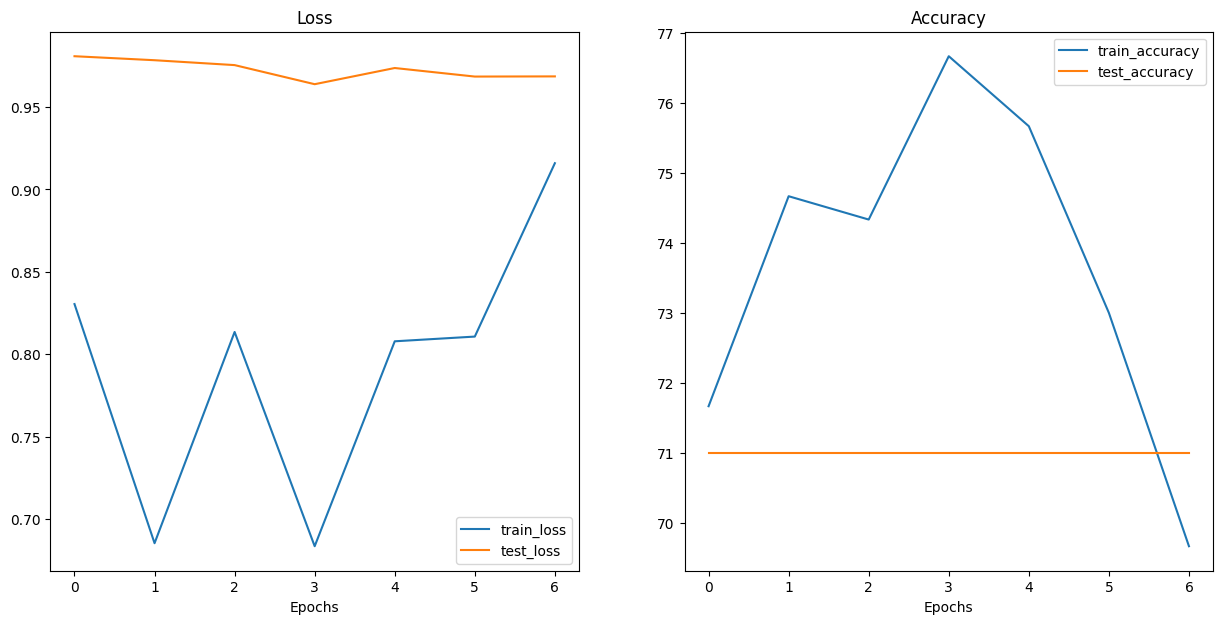

In [74]:
plot_loss_curves(model_1_results) # This is the resnet model @25 epochs

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=1e-2,
                            momentum=0.9,
                            weight_decay=0.0001)
def acc_fn(target, preds):
  """
  Calculates Accuracy.

  Args:
    target: The real data
    preds: Processed logits from the model
  """
  correct = torch.eq(target, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

In [ ]:
from timeit import default_timer as timer

start = timer()

EPOCHS = 50

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        acc_fn=acc_fn,
                        device=device,
                        epochs=EPOCHS)

end = timer()

print(f"Training Time: {end-start:.2f} seconds for {EPOCHS} epochs on {device}.")

  0%|          | 0/1 [00:00<?, ?it/s]



Starting Epoch: 0-----------------------------
Went through 0 batches
|| Train_Accuracy: 32.000 & Train_Loss: 1.143 ||
Went through 2 batches
|| Train_Accuracy: 28.000 & Train_Loss: 1.122 ||
Went through 4 batches
|| Train_Accuracy: 38.000 & Train_Loss: 1.134 ||
|| Train_Accuracy: 35.333 & Train_Loss: 1.107 ||
Training for current epoch completed successfully.
Went through 0 batches
|| Test_Acc: 58.000 & Test_Loss: 0.959 ||


100%|██████████| 1/1 [01:18<00:00, 78.55s/it]

|| Test_Accuracy: 35.000 & Test_Loss: 1.072 ||
Testing for current epoch completed successfully.

Ending Epoch: 0-----------------------------
Time Taken For Current Epoch: 78.55 seconds
Training Time: 78.56 seconds for 1 epochs on cpu.


In [77]:
from pathlib import Path

model_path = Path("/models")
path = model_path / "model_ResNet34.pth"

model_path.mkdir(
    parents=True,
    exist_ok=True
)

torch.save(obj=model_2,
           f=path)

print("Save Success")

Save Success
